In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from tensorflow.keras import layers,regularizers,Sequential,Model,backend,callbacks,optimizers,metrics,losses
import tensorflow as tf
import sys
import json
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.preprocessing import QuantileTransformer
output_path = "../output/resnet/"

In [2]:
# Import train data, drop sig_id, cp_type

train_data = pd.read_csv('../input/lish-moa/train_features.csv')

targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

targets_non_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')



# Import test data

test_data = pd.read_csv('../input/lish-moa/test_features.csv')


# Import predictors from public kernel, https://www.kaggle.com/demetrypascal/t-test-pca-rfe-logistic-regression

json_file_path = '../input/main_predictors.json'

with open(json_file_path, 'r') as j:
    predictors = json.loads(j.read())
    predictors = predictors['start_predictors']

# Feature Engineering

In [3]:


def preprocess_data(train_data, test_data, targets, predictors):
    columns_numeric = ["g-" + str(i) for i in range(772)] + ["c-" + str(i) for i in range(100)]
    GENES = [col for col in train_data.columns if col.startswith('g-')]
    CELLS = [col for col in train_data.columns if col.startswith('c-')]
    
    
    print("performing Rank Gauss")
    #Rank Gauss, makes distribution normal
    transformer = QuantileTransformer(n_quantiles=1000,random_state=0, output_distribution="normal")
    train_data[columns_numeric] = transformer.fit_transform(train_data[columns_numeric])
    test_data[columns_numeric] = transformer.transform(test_data[columns_numeric])

    
    #FEATURES + PCA
    print("performing PCA on GENES")
    #GENES
    n_comp_genes = 100
    pca_genes = PCA(n_components=n_comp_genes, random_state=42)
    train_pca_genes = pca_genes.fit_transform(train_data[GENES])
    test_pca_genes = pca_genes.transform(test_data[GENES])
    #adding columns
    train_pca_genes = pd.DataFrame(train_pca_genes, columns=[f'pca_G-{i}' for i in range(n_comp_genes)])
    test_pca_genes = pd.DataFrame(test_pca_genes, columns=[f'pca_G-{i}' for i in range(n_comp_genes)])
    train_data = pd.concat((train_data, train_pca_genes), axis=1)
    test_data = pd.concat((test_data, test_pca_genes), axis=1)
    print("after PCA on GENES, number of features:", train_data.shape[1])
    
    
    print("performing PCA on CELLS")
    #CELLS
    n_comp_cells = 10
    pca_cells = PCA(n_components=n_comp_cells, random_state=42)
    train_pca_cells = pca_cells.fit_transform(train_data[CELLS])
    test_pca_cells = pca_cells.transform(test_data[CELLS])
    #adding columns
    train_pca_cells = pd.DataFrame(train_pca_cells, columns=[f'pca_G-{i}' for i in range(n_comp_cells)])
    test_pca_cells = pd.DataFrame(test_pca_cells, columns=[f'pca_G-{i}' for i in range(n_comp_cells)])
    train_data = pd.concat((train_data, train_pca_cells), axis=1)
    test_data = pd.concat((test_data, test_pca_cells), axis=1)
    print("after PCA on CELLS, number of features:", train_data.shape[1])
    
    columns_numeric = columns_numeric + [f'pca_G-{i}' for i in range(n_comp_cells)] + [f'pca_G-{i}' for i in range(n_comp_genes)]
    
    print("dropping cp_type and rows with cp_type = ctl_vehicle from train, test and target dataframes")
    train_data = train_data[train_data["cp_type"] != "ctl_vehicle"].drop("cp_type", axis = 1)
    test_data = test_data[test_data["cp_type"] != "ctl_vehicle"].drop("cp_type", axis = 1)
    features_labels = train_data.merge(targets, on='sig_id')
    targets = features_labels[targets.columns]  
    train_data = pd.get_dummies(train_data, columns=['cp_time','cp_dose'])
    test_data = pd.get_dummies(test_data, columns=['cp_time','cp_dose'])
    
    # removing columns not used in training
    targets.drop("sig_id", inplace = True, axis=1)
    train_data.drop("sig_id", inplace = True, axis=1)
    test_data.drop("sig_id", inplace = True, axis=1)
    # input for the second head of ResNet
    train_data2 = train_data[predictors]
    test_data2 = test_data[predictors]
    
    train_data = train_data.to_numpy()
    test_data = test_data.to_numpy()
    targets = targets.to_numpy()
    train_data2 = train_data2.to_numpy()
    test_data2 = test_data2.to_numpy()
    
    return train_data, train_data2, test_data, test_data2,  targets


In [4]:
train_data, train_data2, test_data, test_data2,  targets = preprocess_data(train_data, test_data, targets, predictors)


# for every prediction if our model predicts a value that is lower than p_min or higher than p_max
# then the prediction is forced to p_min or p_max respectively
# Prediction Clipping Thresholds

p_min = 0.0005
p_max = 0.9995

# OOF Evaluation Metric with clipping and no label smoothing

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))




performing Rank Gauss
performing PCA on GENES
after PCA on GENES, number of features: 976
performing PCA on CELLS
after PCA on CELLS, number of features: 986
dropping cp_type and rows with cp_type = ctl_vehicle from train, test and target dataframes


# Model

In [5]:
# to see model architecture view the image below

def build_model(n_features, n_features_2, n_labels, label_smoothing = 0.001):  
    # 2 input layers  
    input_1 = layers.Input(shape = (n_features,), name = 'Input1')
    input_2 = layers.Input(shape = (n_features_2,), name = 'Input2')

    head_1 = Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(512, activation="elu"), 
        layers.BatchNormalization(),
        layers.Dense(256, activation = "elu")
        ],name='Head1') 

    input_3 = head_1(input_1)
    input_3_concat = layers.Concatenate()([input_2, input_3])

    head_2 = Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(512, "relu"),
        layers.BatchNormalization(),
        layers.Dense(512, "elu"),
        layers.BatchNormalization(),
        layers.Dense(256, "relu"),
        layers.BatchNormalization(),
        layers.Dense(256, "elu")
        ],name='Head2')

    input_4 = head_2(input_3_concat)
    input_4_avg = layers.Average()([input_3, input_4]) 

    head_3 = Sequential([
        layers.BatchNormalization(),
        layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'),
        layers.BatchNormalization(),
        layers.Dense(n_labels, kernel_initializer='lecun_normal', activation='selu'),
        layers.BatchNormalization(),
        layers.Dense(n_labels, activation="sigmoid")
        ],name='Head3')

    output = head_3(input_4_avg)


    model = Model(inputs = [input_1, input_2], outputs = output)
    model.compile(optimizer='adam', loss=losses.BinaryCrossentropy(label_smoothing=label_smoothing), metrics=logloss)
    
    return model

In [7]:
import pydot
import graphviz
n_features = train_data.shape[1]
n_features2 = train_data2.shape[1]
n_labels = targets.shape[1]
model = build_model(n_features, n_features2, n_labels)
# the following line may not work on your system, getting the following error: 
# ('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
# even though pydot and graphviz are installed
# We apologize for the inconvenience if this does not work on your system, you can see the model architecture on the project report
tf.keras.utils.plot_model(model,show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# Training

In [6]:
# Generate Seeds

n_seeds = 7

seeds = [10, 11, 12, 13, 14, 15, 16]

# Training Loop
n_test = test_data.shape[0]
n_labels = targets.shape[1]

n_folds = 10
y_pred = np.zeros((n_test,n_labels))
oof_for_blend = np.zeros((train_data.shape[0], n_labels))

oof = tf.constant(0.0)
hists = []

# this takes a while..

for seed in seeds:
    print("current seed:", seed)
    fold = 0

    kf = KFold(n_splits=n_folds,shuffle=True,random_state=seed)
    for train, test in kf.split(train_data):
        
        X_train, X_test = train_data[train], train_data[test]
        
        
        X_train_2 = train_data2[train]
        X_test_2 = train_data2[test]
        
        y_train = targets[train]
        y_test = targets[test]
        n_features = X_train.shape[1]
        n_features_2 = X_train_2.shape[1]

        model = build_model(n_features, n_features_2, n_labels)
        
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_logloss', factor=0.1, patience=2, mode='min', min_lr=1E-5)
        early_stopping = callbacks.EarlyStopping(monitor='val_logloss', min_delta=1E-5, patience=10, mode='min',restore_best_weights=True)

        hist = model.fit([X_train,X_train_2],y_train, batch_size=16, epochs=1,verbose=1,validation_data = ([X_test,X_test_2],y_test),
                         callbacks=[reduce_lr, early_stopping])
        hists.append(hist)
        
        # Save Model
        model.save(output_path + 'TwoHeads_seed_'+str(seed)+'_fold_'+str(fold))


        # OOF Score
        y_val = model.predict([X_test,X_test_2])
        oof_for_blend[test] += np.clip(y_val, p_min, p_max) / n_seeds
        
        oof += logloss(tf.constant(y_test,dtype=tf.float32),tf.constant(y_val,dtype=tf.float32))/(n_folds*n_seeds)

        # Run prediction
        y_pred += model.predict([test_data, test_data2])/(n_folds*n_seeds)

        fold += 1

current seed: 10
1235/1235 [==============================] - 16s 13ms/step - loss: 0.0714 - logloss: 0.0688 - val_loss: 0.0222 - val_logloss: 0.0190
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../output/resnet/TwoHeads_seed_10_fold_0\assets
1235/1235 [==============================] - 16s 13ms/step - loss: 0.0706 - logloss: 0.0680 - val_loss: 0.0226 - val_logloss: 0.0194
INFO:tensorflow:Assets written to: ../output/resnet/TwoHeads_seed_10_fold_1\assets
1235/1235 [==============================] - 16s 13ms/step - loss: 0.0705 - logloss: 0.0680 - val_loss: 0.0219 - val_logloss: 0.0187
INFO:tensorflow:Assets written to: ../output/resnet/TwoHeads_seed_10_fold_2\assets
1235/1235 [==============================] - 16s 13ms/step - loss: 0.0709 - logloss: 0.0683 - val_los

KeyboardInterrupt: 

In [7]:
import tensorflow.keras as keras

#model = keras.models.load_model("./TwoHeads_seed_1_fold_0", custom_objects={'logloss':logloss})
#model.save("./TwoHeads_seed_1_fold_0")

In [8]:
import pickle

file = open(output_path + "oof", "wb")
pickle.dump(oof_for_blend, file)
file.close()

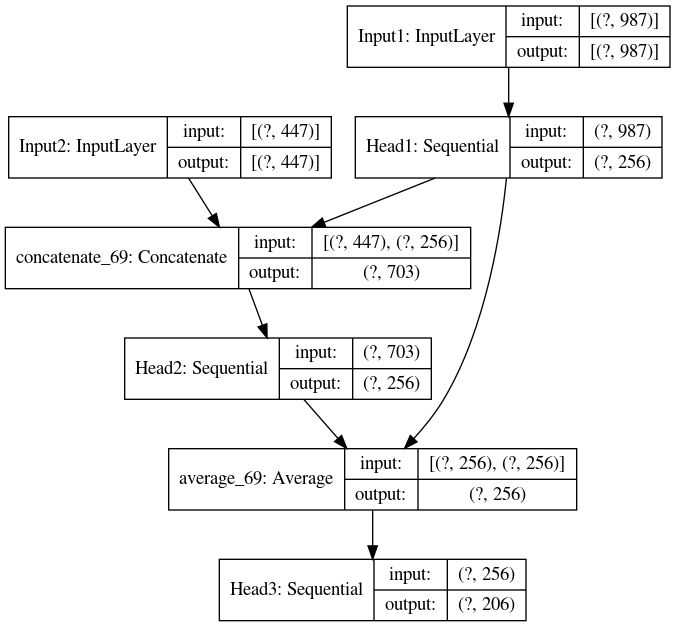

In [9]:
# Model Architecture

tf.keras.utils.plot_model(model,show_shapes=True)

OOF score is  0.0164092891


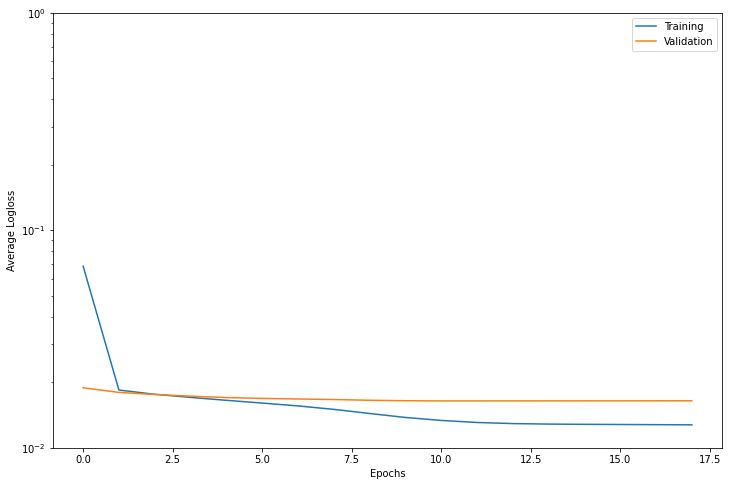

In [10]:
# Analysis of Training

tf.print('OOF score is ',oof)

plt.figure(figsize=(12,8))

hist_trains = []
hist_lens = []
for i in range(n_folds*n_seeds):
    hist_train = (hists[i]).history['logloss']
    hist_trains.append(hist_train)
    hist_lens.append(len(hist_train))
hist_train = []
for i in range(min(hist_lens)):
    hist_train.append(np.mean([hist_trains[j][i] for j in range(n_folds*n_seeds)]))

plt.plot(hist_train)

hist_vals = []
hist_lens = []
for i in range(n_folds*n_seeds):
    hist_val = (hists[i]).history['val_logloss']
    hist_vals.append(hist_val)
    hist_lens.append(len(hist_val))
hist_val = []
for i in range(min(hist_lens)):
    hist_val.append(np.mean([hist_vals[j][i] for j in range(n_folds*n_seeds)]))

plt.plot(hist_val)

plt.yscale('log')
plt.yticks(ticks=[1,1E-1,1E-2])
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [11]:
# Generate submission file, Clip Predictions

sub = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
y_pred = np.clip(y_pred,p_min,p_max)
sub.iloc[test_features['cp_type'] != 'ctl_vehicle',1:] = y_pred

# Set ctl_vehicle to 0
sub.iloc[test_features['cp_type'] == 'ctl_vehicle',1:] = 0

# Save Submission
sub.to_csv('submission.csv', index=False)